# Theme 2 - Climate Variability, Ocean Circulation, and Ecosystem
## Ocean Circulation, Mixing, and Ecosystem
OOI Data Labs Education Nuggets

**Objective**: Demonstrate how to download CTD and fluorometer data from an Endurance glider, and Bulk Meteorology data from an Endurance surface mooring using the Machine-to-Machine (M2M) interface, remove outliers, calculate depth-binned hourly averages, and export the data as a .csv file. We also demonstrate how to make a map of a glider track.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # for mapping
from mpl_toolkits.axes_grid1 import make_axes_locatable # for mapping

## 1. Request Data from OOINet

* **Coastal Endurance** - CTD and fluorometer data from Endurance Glider 320, and Sea Surface Temperature from the Endurance the Oregon Shelf Surface Mooring
    * Instruments, data streams, parameters:
        * CE05MOAS-GL320-05-CTDGVM000
            * ctdgv_m_glider_instrument_recovered: sci_water_pressure_dbar, sci_water_temp
        * CE05MOAS-GL320-02-FLORTM000
            * flort_m_sample: int_ctd_pressure, sci_flbbcd_chlor_units
        * CE02SHSM-SBD11-06-METBKA000
            * metbk_a_dcl_instrument_recovered: sea_surface_temperature
    * Time range: 2016-07-15 to 2016-09-15
    * Delivery method: recovered_host

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the three instruments of interest. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# CTD_url = request_data('CE05MOAS-GL320-05-CTDGVM000', 'recovered_host', 'ctdgv_m_glider_instrument_recovered',
#                        '2016-07-15T00:00:00.000Z', '2016-09-15T00:00:00.000Z')
# 
# FLORT_url = request_data('CE05MOAS-GL320-02-FLORTM000', 'recovered_host', 'flort_m_sample',
#                          '2016-07-15T00:00:00.000Z', '2016-09-15T00:00:00.000Z')
# 
# METBK_url = request_data('CE02SHSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_a_dcl_instrument_recovered',
#                          '2016-07-15T00:00:00.000Z', '2016-09-15T00:00:00.000Z')
# print('CTD_url: %s' %CTD_url)
# print('FLORT_url: %s' %FLORT_url)
# print('METBK_url: %s' %METBK_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [2]:
CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191021T144742362Z-CE05MOAS-GL320-05-CTDGVM000-recovered_host-ctdgv_m_glider_instrument_recovered/catalog.html'
FLORT_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191021T144742539Z-CE05MOAS-GL320-02-FLORTM000-recovered_host-flort_m_sample/catalog.html'
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191021T144742762Z-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [3]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables of interest and get the data for the three datasets. Side note: we want to grab latitude and longitude from the glider CTD file. The variable used to be the coordinates 'lat' and 'lon' in the NetCDF files. The system has changed and now the variable is called 'm_gps_lat' and m_gps_lon'. These variables are technically the true GPS measurements taken by the glider at the surface. However, the OOI system has interpolated the values to fill in data when the glider is underwater. If this changes again in the future, the user will need to find the correct latitude and longitude variable name in the NetCDF file.

In [4]:
# Specify the variable(s) of interest and get the data for the three datasets
CTD_var = ['sci_water_pressure_dbar', 'sci_water_temp', 'm_gps_lat', 'm_gps_lon']
FLORT_var = ['int_ctd_pressure', 'sci_flbbcd_chlor_units']
METBK_var = ['sea_surface_temperature']

CTD_data, CTD_units = get_data(CTD_url, CTD_var)
FLORT_data, FLORT_units = get_data(FLORT_url, FLORT_var)
METBK_data, METBK_units = get_data(METBK_url, METBK_var)
print(CTD_units)
print(FLORT_units)
print(METBK_units)

Appending data from files
Appending data from files
Appending data from files
{'sci_water_pressure_dbar': ['dbar'], 'sci_water_temp': ['ºC'], 'm_gps_lat': ['degree_north'], 'm_gps_lon': ['degree_east']}
{'int_ctd_pressure': ['dbar'], 'sci_flbbcd_chlor_units': ['µg L-1']}
{'sea_surface_temperature': ['ºC']}


## Quick Data Plots
First, make quick time-series plots to make sure you downloaded the correct data. For gliders this isn't the best way to visualize the data because they are collected by depth, but this is just a way to quickly look at the data and see if there are any obvious issues.

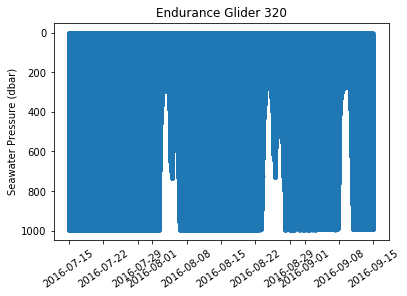

In [5]:
fig, ax = plt.subplots()
plt.plot(CTD_data['time'], CTD_data['sci_water_pressure_dbar'], '.')
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure ({})'.format(CTD_units['sci_water_pressure_dbar'][0]))
ax.set_title('Endurance Glider 320')
plt.xticks(rotation=35);

Looks like the glider profiled to approximately 1000 m. Now quickly plot temperature.

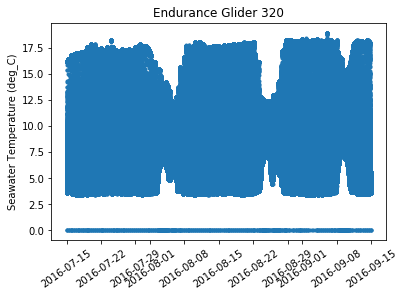

In [6]:
fig, ax = plt.subplots()
plt.plot(CTD_data['time'], CTD_data['sci_water_temp'], '.')
ax.set_xlabel('')
ax.set_ylabel('Seawater Temperature (deg_C)')
ax.set_title('Endurance Glider 320')
plt.xticks(rotation=35);

You can see in this plot that temperatures range from approximately 3-18 degrees Celsius (which makes sense as the glider is moving up and down in the water column), but there is also a weird line of values at zero. Slocum gliders use zero as a fill value when the glider is at the surface, so these values of 0.00 should be thrown out. Here is a function to remove values of 0.00 from the data frame:

In [7]:
# this function can only be used if the expected values are always >0
def remove_zeros(df, variables):
    cnames = []
    for v in variables:
        if 'm_gps_' not in v:
            cname = v + '_ind'
            cnames.append(cname)
            df[cname] = df[v] > 0.00
    for cn in cnames:
        df = df.loc[df[cn] == True]
    df = df.drop(columns=cnames)
    return df

Plot temperature again to see if the 0.00 values were removed.

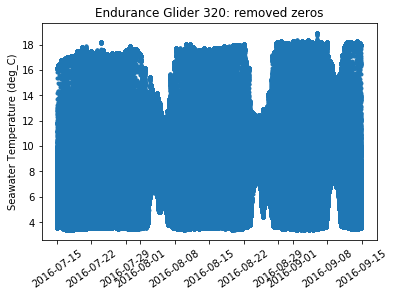

In [8]:
CTD_data = remove_zeros(CTD_data, CTD_var)

fig, ax = plt.subplots()
plt.plot(CTD_data['time'], CTD_data['sci_water_temp'], '.')
ax.set_xlabel('')
ax.set_ylabel('Seawater Temperature (deg_C)')
ax.set_title('Endurance Glider 320: removed zeros')
plt.xticks(rotation=35);

Looks good! Let's quickly plot the glider chlorophyll-a data.

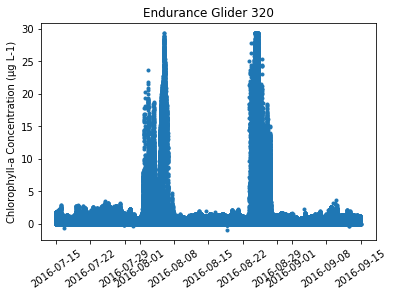

In [9]:
# quickly plot chl-a data
fig, ax = plt.subplots()
plt.plot(FLORT_data['time'], FLORT_data['sci_flbbcd_chlor_units'], '.')
ax.set_xlabel('')
ax.set_ylabel('Chlorophyll-a Concentration ({})'.format(FLORT_units['sci_flbbcd_chlor_units'][0]))
ax.set_title('Endurance Glider 320')
plt.xticks(rotation=35);

It looks like there are some negative chlorophyll values - these are within the noise range of the instrument but are invalid, so let's get rid of values less than zero with the same function we used above, and re-plot.

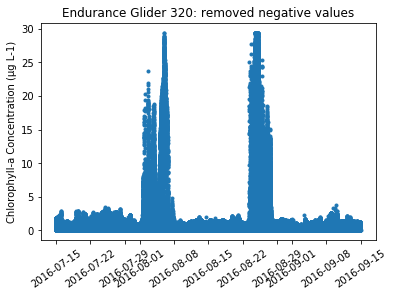

In [10]:
FLORT_data = remove_zeros(FLORT_data, FLORT_var)

fig, ax = plt.subplots()
plt.plot(FLORT_data['time'], FLORT_data['sci_flbbcd_chlor_units'], '.')
ax.set_xlabel('')
ax.set_ylabel('Chlorophyll-a Concentration ({})'.format(FLORT_units['sci_flbbcd_chlor_units'][0]))
ax.set_title('Endurance Glider 320: removed negative values')
plt.xticks(rotation=35);

Ok! Now that the glider data are cleaned up a bit, let's plot the sea surface temperature data from the Endurance the Oregon Shelf Surface Mooring

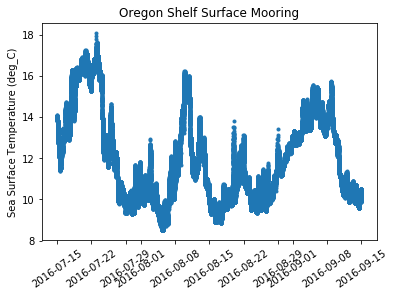

In [11]:
fig, ax = plt.subplots()
plt.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], '.')
ax.set_xlabel('')
ax.set_ylabel('Sea Surface Temperature (deg_C)')
ax.set_title('Oregon Shelf Surface Mooring')
plt.xticks(rotation=35);

## 3. Merge and export
Now let's work on merging and exporting the datasets as .csv files. We will export the glider dataset in a separate .csv file from the sea surface temperature from the surface mooring since the glider dataset is indexed by depth along with time. First, we want to downsample the glider data because it is such a high-resolution dataset (about 1 sample every 2 seconds). This example will demonstrate how to calculate averages by 5 dbar depth bins by hour (so we retain the time series format). This section of code will take a few seconds to complete.

In [12]:
# cut off the minutes and seconds in the time stamp
CTD_data['time'] = CTD_data['time'].apply(lambda t: t.strftime('%Y-%m-%d %H'))

# create a new column in the dataframe with pressure rounded to the nearest 5 dbar
CTD_data['Pressure Bin (dbar)'] = (5 * round(CTD_data['sci_water_pressure_dbar']/5))

# calculate depth-binned averages by time
CTD_data_binned = CTD_data.groupby(['time', 'Pressure Bin (dbar)']).mean()

# repeat for the fluorometer dataset
FLORT_data['time'] = FLORT_data['time'].apply(lambda t: t.strftime('%Y-%m-%d %H'))
FLORT_data['Pressure Bin (dbar)'] = (5 * round(FLORT_data['int_ctd_pressure']/5))
FLORT_data_binned = FLORT_data.groupby(['time', 'Pressure Bin (dbar)']).mean()

In [13]:
# merge the two datasets on time and pressure bin, and make sure the resulting dataframe is sorted by time
glider_data = pd.merge(CTD_data_binned, FLORT_data_binned, on=['time', 'Pressure Bin (dbar)'], how='outer').reset_index()
glider_data = glider_data.sort_values(['time', 'Pressure Bin (dbar)'])
glider_data = glider_data.drop(columns=['sci_water_pressure_dbar', 'int_ctd_pressure'])

# rename the columns and add units
glider_data = glider_data.rename(columns={'sci_water_temp': 'Seawater Temperature (deg_C)',
                                          'm_gps_lat': 'Latitude ({})'.format(CTD_units['m_gps_lat'][0]),
                                          'm_gps_lon': 'Longitude ({})'.format(CTD_units['m_gps_lon'][0]),
                                          'sci_flbbcd_chlor_units': 'Chl-a Concentration ({})'.format(FLORT_units['sci_flbbcd_chlor_units'][0])})
# convert time from a object to a datetime
glider_data['time'] = glider_data['time'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H'))

# print the column names of the new merged dataframe
print(glider_data.columns)

Index(['time', 'Pressure Bin (dbar)', 'Seawater Temperature (deg_C)',
       'Latitude (degree_north)', 'Longitude (degree_east)',
       'Chl-a Concentration (µg L-1)'],
      dtype='object')


Now that we have our downsampled and merged dataframe, let's plot the variables again in a different way. First, we'll make a map so we can see where the glider was flying. Here is a function to return all of the locations of the Endurance moorings, using the Rutgers OOI Data Review Database.

In [29]:
def return_array_subsites_standard_loc(array):
    DBurl= 'https://datareview.marine.rutgers.edu/regions/view/{}.json'.format(array)
    r = requests.get(DBurl)
    url_ct = r.json()['region']['sites']
    loc_df = pd.DataFrame()
    for ii in range(len(url_ct)):
        if url_ct[ii]['reference_designator'] != 'CP05MOAS':
            data = {
                    'lat': url_ct[ii]['latitude'],
                    'lon': url_ct[ii]['longitude'],
                    'max_z': url_ct[ii]['max_depth']
                    }
            new_r = pd.DataFrame(data, columns=['lat', 'lon', 'max_z'], index=[url_ct[ii]['reference_designator']])
            loc_df = loc_df.append(new_r)
    return loc_df

In [30]:
array_loc = return_array_subsites_standard_loc('CE')
print(array_loc)

              lat      lon  max_z
CE01ISSM  44.6598 -124.095     25
CE01ISSP  44.6620 -124.096     25
CE02SHBP  44.6371 -124.306     79
CE02SHSM  44.6393 -124.304     80
CE02SHSP  44.6372 -124.299     81
CE04OSBP  44.3695 -124.954    579
CE04OSPD  44.3683 -124.953    576
CE04OSPS  44.3741 -124.956    588
CE04OSSM  44.3811 -124.956    588
CE05MOAS      NaN      NaN   1000
CE06ISSM  47.1336 -124.272     29
CE06ISSP  47.1360 -124.269     29
CE07SHSM  46.9859 -124.566     87
CE07SHSP  46.9843 -124.565     87
CE09OSPM  46.8517 -124.982    544
CE09OSSM  46.8508 -124.972    542


Now we can make a map of the Endurance array with the glider track from the latitude and longitude information from the file.

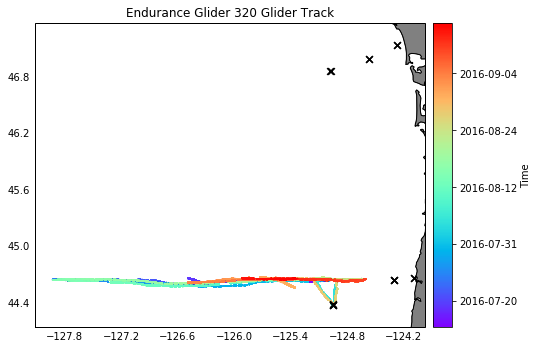

In [31]:
import cartopy.feature as cfeature
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.subplots_adjust(right=0.85)
states = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black", facecolor='grey')
ax.add_feature(cfeature.RIVERS, zorder=10, facecolor='white')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = False
gl.ylines = False
ax.coastlines('10m', linewidth=1)
ax.set_title('Endurance Glider 320 Glider Track')

lims = [-128.12, -123.97, 44.14, 47.37] # define the limits of the Endurance array
ax.set_extent(lims, crs=ccrs.PlateCarree())

londata = glider_data['Longitude (degree_east)']
latdata = glider_data['Latitude (degree_north)']
tm = glider_data['time']
sct = plt.scatter(londata, latdata, c=tm, marker='.', s=2, cmap='rainbow', transform=ccrs.Geodetic())
plt.scatter(array_loc.lon, array_loc.lat, s=45, marker='x', color='k')  # add the mooring locations
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(sct, cax=cax, label='Time')
cbar.ax.set_yticklabels(pd.to_datetime(cbar.ax.get_yticks()).strftime(date_format='%Y-%m-%d'));

During this time period, the glider ran a relatively straight line on the Oregon line of the Endurance array, off of Newport, OR.

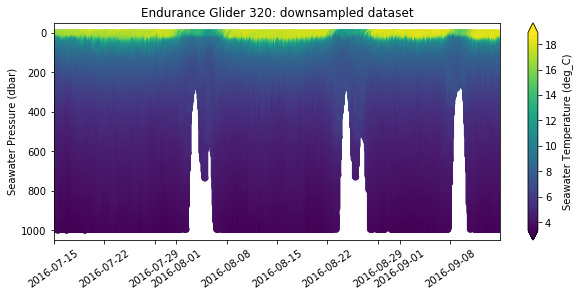

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
xc = ax.scatter(np.array(glider_data['time']), glider_data['Pressure Bin (dbar)'], c=glider_data['Seawater Temperature (deg_C)'])
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure (dbar)')
bar = fig.colorbar(xc, ax=ax, label='Seawater Temperature (deg_C)', extend='both')
ax.set_title('Endurance Glider 320: downsampled dataset')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(glider_data['time']), np.nanmax(glider_data['time'])]);

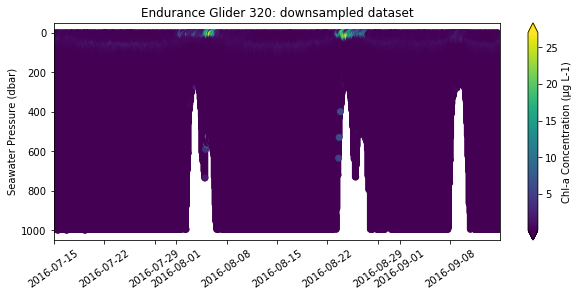

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
xc = ax.scatter(np.array(glider_data['time']), glider_data['Pressure Bin (dbar)'], c=glider_data['Chl-a Concentration (µg L-1)'])
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure (dbar)')
bar = fig.colorbar(xc, ax=ax, label='Chl-a Concentration (µg L-1)', extend='both')
ax.set_title('Endurance Glider 320: downsampled dataset')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(glider_data['time']), np.nanmax(glider_data['time'])]);

This dataset looks good, so we can export it as a .csv file.

In [19]:
glider_data.to_csv(os.path.join(save_dir, 'Theme2b_Endurance_glider_data_depthavg.csv'), index=False)

Now let's calculate hourly averages for the Sea Surface Temperature from the Oregon Shelf Surface Mooring, and export.

In [20]:
METBK_hourly = METBK_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# rename the columns and add units
METBK_hourly = METBK_hourly.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)'})

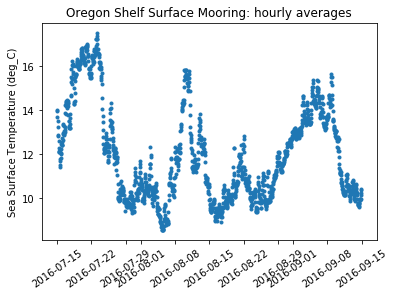

In [21]:
# Plot to make sure the data are reasonable
fig, ax = plt.subplots()
plt.plot(METBK_hourly['time'], METBK_hourly['Sea Surface Temperature (deg_C)'], '.')
ax.set_xlabel('')
ax.set_ylabel('Sea Surface Temperature (deg_C)')
ax.set_title('Oregon Shelf Surface Mooring: hourly averages')
plt.xticks(rotation=35);

In [22]:
# export to .csv
METBK_hourly.to_csv(os.path.join(save_dir, 'Theme2b_Endurance_sea_surface_temp.csv'), index=False)